In [ ]:
import matplotlib.pyplot as plt
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="rfYCcNnmeIoqGxOhC7RA")
project = rf.workspace("joseph-nelson").project("thermal-dogs-and-people")
version = project.version(6)
dataset = version.download("multiclass")

In [1]:
import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt

# Define paths
train_dir = "data/train/"
test_dir = "data/test/"
valid_dir = "data/valid/"

train_labels_path = os.path.join(train_dir, "_classes.csv")
test_labels_path = os.path.join(test_dir, "_classes.csv")
valid_labels_path = os.path.join(valid_dir, "_classes.csv")

# Load labels
train_labels_df = pd.read_csv(train_labels_path)
train_labels_df.set_index('filename', inplace=True)
test_labels_df = pd.read_csv(test_labels_path)
test_labels_df.set_index('filename', inplace=True)
valid_labels_df = pd.read_csv(valid_labels_path)
valid_labels_df.set_index('filename', inplace=True)

IMG_SIZE = (224, 224)

In [2]:
# Function to load and resize image to the intermediate dataset size
def load_and_resize_image(filename, labels):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    # image = image / 255.0  # Normalize to [0,1] range
    return image, labels

def get_labels(filename):
    # Convert EagerTensor filename to a string
    filename_str = filename.numpy().decode("utf-8")
    if filename_str in train_labels_df.index:
        labels = train_labels_df.loc[filename_str].values
        return labels.astype('float32')
    else:
        # Return a default label or handle the missing label case
        # Here we return a default value; adjust based on your use case
        return tf.constant([0.0, 0.0], dtype=tf.float32)  # Example default label


def process_path(file_path):
    # Obtain the filename without the directory path
    filename = tf.strings.split(file_path, os.sep)[-1]
    labels = tf.py_function(get_labels, [filename], tf.float32)
    return load_and_resize_image(file_path, labels)

# Function to create intermediate dataset
def create_intermediate_dataset(directory, labels_df):
    file_paths = [os.path.join(directory, fname) for fname in labels_df.index]
    ds = tf.data.Dataset.from_tensor_slices(file_paths)
    ds = ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(32).prefetch(tf.data.AUTOTUNE)
    return ds

In [3]:
# Creating intermediate datasets for train, test, and validation
train_ds = create_intermediate_dataset(train_dir, train_labels_df)
test_ds = create_intermediate_dataset(test_dir, test_labels_df)
valid_ds = create_intermediate_dataset(valid_dir, valid_labels_df)


In [4]:
# Ensure that `tf.py_function` is called with eager execution enabled
tf.config.run_functions_eagerly(True)

# Create the intermediate dataset again with the updated function
# train_ds = create_intermediate_dataset(train_dir, train_labels_df)

# Verify by taking a batch
for images, labels in train_ds.take(1):
    print(images.shape, labels.shape)

(32, 224, 224, 3) (32, 2)


2024-11-02 20:17:40.869516: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


tf.Tensor([1. 0.], shape=(2,), dtype=float32)
tf.Tensor([0. 1.], shape=(2,), dtype=float32)


2024-11-02 20:17:40.944707: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


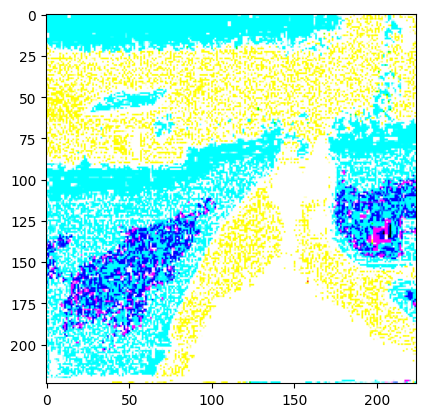

In [5]:
for i, j in train_ds.take(2):
    plt.imshow(i[0])
    print(j[0])

/Users/thory/miniconda3/envs/tiny-ml/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].


ResNet-preprocessed images: (32, 224, 224, 3)


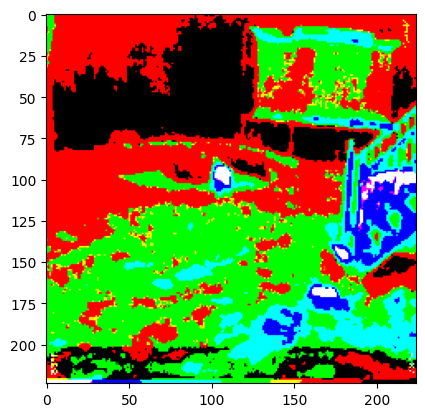

In [6]:
def apply_preprocessing(dataset, preprocess_fn):
    return dataset.map(lambda image, label: (preprocess_fn(image), label), num_parallel_calls=tf.data.AUTOTUNE)

# Example of how to prepare the dataset for specific models
resnet_train_ds = apply_preprocessing(train_ds, tf.keras.applications.resnet.preprocess_input)
resnet_test_ds = apply_preprocessing(test_ds, tf.keras.applications.resnet.preprocess_input)
resnet_valid_ds = apply_preprocessing(valid_ds, tf.keras.applications.resnet.preprocess_input)
mobilenet_train_ds = apply_preprocessing(train_ds, tf.keras.applications.mobilenet.preprocess_input)
mobilenet_test_ds = apply_preprocessing(test_ds, tf.keras.applications.resnet.preprocess_input)
mobilenet_valid_ds = apply_preprocessing(valid_ds, tf.keras.applications.resnet.preprocess_input)
inception_train_ds = apply_preprocessing(train_ds, tf.keras.applications.inception_v3.preprocess_input)
inception_test_ds = apply_preprocessing(test_ds, tf.keras.applications.resnet.preprocess_input)
inception_valid_ds = apply_preprocessing(valid_ds, tf.keras.applications.resnet.preprocess_input)

# Checking a batch of each preprocessed dataset
for images, labels in resnet_train_ds.take(1):
    print("ResNet-preprocessed images:", images.shape)
    plt.imshow(images[0])


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define model-specific parameters
epochs = 10
batch_size = 32
learning_rate = 1e-4

# Model training function
def compile_and_train(model, train_ds, val_ds, epochs, learning_rate):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)
    return history

# Function to create base model (ResNet, MobileNet, or Inception)
def create_model(base_model_class):
    base_model = base_model_class(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(2, activation='sigmoid')
    ])
    return model

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.3836 - loss: 0.8254 - val_accuracy: 0.1951 - val_loss: 1.2865
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.4350 - loss: 0.7481 - val_accuracy: 0.3659 - val_loss: 1.1065
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.5753 - loss: 0.6992 - val_accuracy: 0.4634 - val_loss: 0.9844
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.5729 - loss: 0.6680 - val_accuracy: 0.4878 - val_loss: 0.9190
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.6371 - loss: 0.6451 - val_accuracy: 0.4878 - val_loss: 0.8979
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.6593 - loss: 0.6245 - val_accuracy: 0.4634 - val_loss: 0.9052
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.6671 - loss: 0.6050 - val_accuracy: 0.4390 - val_loss: 0.9260
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.6708 - loss: 0.5871 - val_accuracy: 0.4146 - val_loss: 0.9483
Epoch 9/

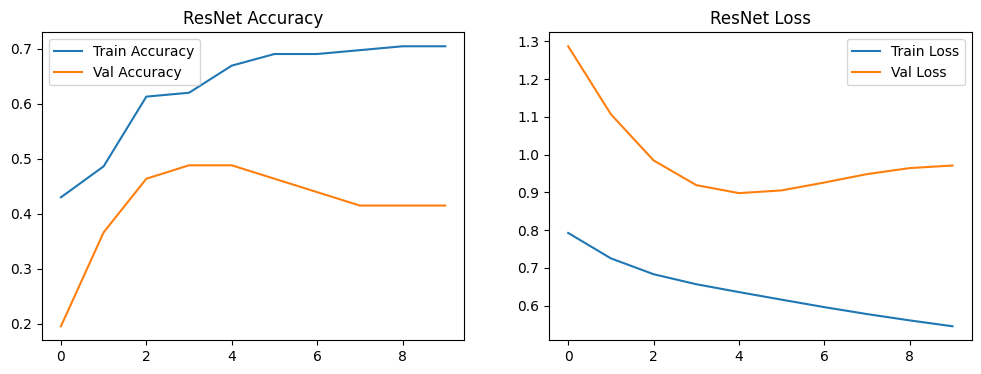

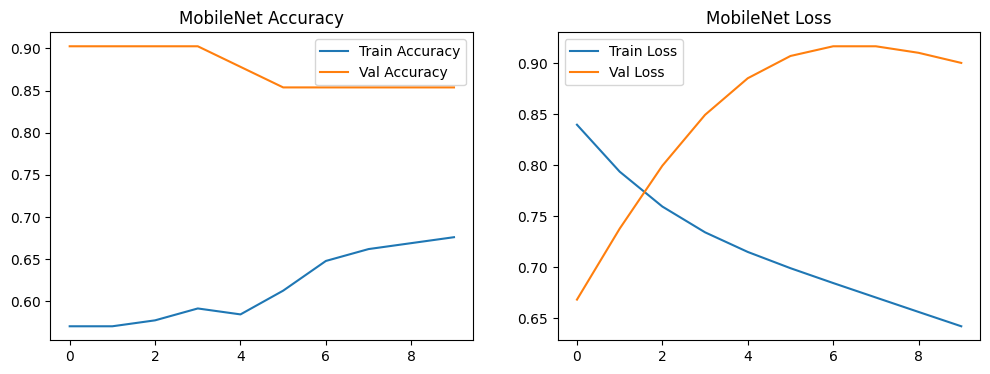

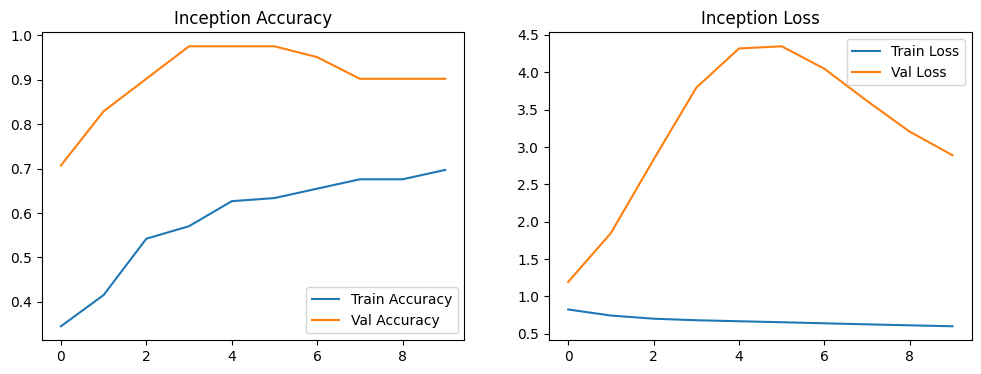

In [8]:
import matplotlib.pyplot as plt

# Initialize and train each model
resnet_model = create_model(tf.keras.applications.ResNet50)
mobilenet_model = create_model(tf.keras.applications.MobileNetV2)
inception_model = create_model(tf.keras.applications.InceptionV3)

# Train models and collect histories
resnet_history = compile_and_train(resnet_model, resnet_train_ds, resnet_valid_ds, epochs, learning_rate)
mobilenet_history = compile_and_train(mobilenet_model, mobilenet_train_ds, mobilenet_valid_ds, epochs, learning_rate)
inception_history = compile_and_train(inception_model, inception_train_ds, inception_valid_ds, epochs, learning_rate)

# Plot learning curves
def plot_learning_curves(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
    ax1.set_title(f'{model_name} Accuracy')
    ax1.legend()

    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Val Loss')
    ax2.set_title(f'{model_name} Loss')
    ax2.legend()

    plt.show()

plot_learning_curves(resnet_history, 'ResNet')
plot_learning_curves(mobilenet_history, 'MobileNet')
plot_learning_curves(inception_history, 'Inception')


In [10]:
def fine_tune_model(model, train_ds, val_ds, fine_tune_at, learning_rate=1e-5, epochs=5):
    # Unfreeze layers for fine-tuning
    model.layers[0].trainable = True
    for layer in model.layers[0].layers[:fine_tune_at]:
        layer.trainable = False

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)
    return history

# Fine-tune models
fine_tune_epochs = 5
resnet_fine_history = fine_tune_model(resnet_model, resnet_train_ds, resnet_valid_ds, fine_tune_at=100, epochs=fine_tune_epochs)
mobilenet_fine_history = fine_tune_model(mobilenet_model, mobilenet_train_ds, mobilenet_valid_ds, fine_tune_at=100, epochs=fine_tune_epochs)
inception_fine_history = fine_tune_model(inception_model, inception_train_ds, inception_valid_ds, fine_tune_at=249, epochs=fine_tune_epochs)


Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - accuracy: 0.7077 - loss: 0.6490 - val_accuracy: 0.4146 - val_loss: 1.0745
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step - accuracy: 0.8671 - loss: 0.4056 - val_accuracy: 0.4146 - val_loss: 1.1746
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.9288 - loss: 0.2888 - val_accuracy: 0.3659 - val_loss: 1.2674
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.8982 - loss: 0.2144 - val_accuracy: 0.4146 - val_loss: 1.3492
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.8984 - loss: 0.1645 - val_accuracy: 0.3902 - val_loss: 1.4182
Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6628 - loss: 0.6500 - val_accuracy: 0.8293 - val_loss: 0.8869
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7733 - loss: 0.5548 - val_accuracy: 0.8049 - val_loss: 0.8771
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8194 - loss: 0.4879 - val_accuracy: 0.8293 - val_loss: 0.8686
Epoch 4/5
5/5 ━━━━━

In [11]:
def evaluate_model(model, test_ds):
    loss, accuracy = model.evaluate(test_ds)
    return loss, accuracy

# Evaluate each model on the test dataset
resnet_results = evaluate_model(resnet_model, resnet_test_ds)
mobilenet_results = evaluate_model(mobilenet_model, mobilenet_test_ds)
inception_results = evaluate_model(inception_model, inception_test_ds)

# Compile results into a table
results = {
    'Model': ['ResNet', 'MobileNet', 'Inception'],
    'Test Loss': [resnet_results[0], mobilenet_results[0], inception_results[0]],
    'Test Accuracy': [resnet_results[1], mobilenet_results[1], inception_results[1]]
}
results_df = pd.DataFrame(results)
print(results_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step - accuracy: 0.4000 - loss: 1.5495
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.8500 - loss: 0.9267
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step - accuracy: 0.8500 - loss: 3.8901
       Model  Test Loss  Test Accuracy
0     ResNet   1.549455           0.40
1  MobileNet   0.926681           0.85
2  Inception   3.890050           0.85
